In [120]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as ltb
from sklearn.neural_network import MLPClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [121]:
# initial some global parameters
static_end = 5413137

# Import data

In [122]:
s101 = pd.read_csv('data/emg.csv', header = None)
label = pd.read_csv('data/grasp.csv', header = None)
grasprepetition = pd.read_csv('data/grasprepetition.csv', header = None)


s101_static = s101.iloc[0:static_end]
label_static = label.iloc[0:static_end]
grasprepetition_static = grasprepetition.iloc[0:static_end]

In [123]:
s101_static.info()
label_static.info()
grasprepetition_static.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413137 entries, 0 to 5413136
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
dtypes: float64(12)
memory usage: 495.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413137 entries, 0 to 5413136
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   0       int64
dtypes: int64(1)
memory usage: 41.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413137 entries, 0 to 5413136
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   0       int64
dtypes: int64(1)
memory usage: 41.3 MB


# Plot signals and labels

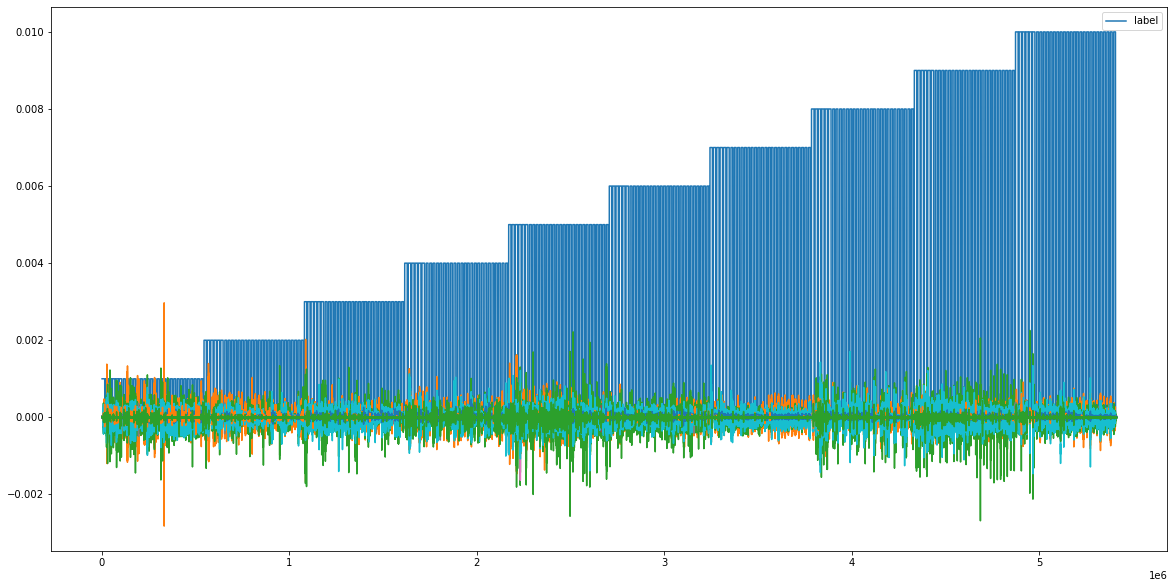

In [124]:
index = np.array(s101_static.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(label_static*0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, s101_static[i])
    
line1.set_label('label')
ax.legend()
plt.show()

# Find training set and testing set

In [125]:
# get the grasprepetition [1,9] as raw training data, [10,12] as raw testing data
train_index = []
test_index = []
for i in tqdm(range(len(grasprepetition_static))):
    if grasprepetition_static.iloc[i,0] in [1,2,3,4,5,6,7,8,9]:
        train_index.append(i)
    if grasprepetition_static.iloc[i,0] in [10,11,12]:
        test_index.append(i)

In [126]:
trainx = s101_static.iloc[train_index].reset_index(drop=True)
trainy = label_static.iloc[train_index].reset_index(drop=True)

testx1 = s101_static.iloc[test_index].reset_index(drop=True)
testy1 = label_static.iloc[test_index].reset_index(drop=True)


In [127]:
trainx
trainy

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.102400e-06,0.000002,4.904000e-07,-6.724600e-06,-2.476400e-07,6.831800e-07,1.010400e-06,1.195800e-08,1.117000e-06,-6.362200e-06,4.968400e-06,-3.684700e-07
1,2.437700e-06,0.000001,-1.859500e-06,-5.549600e-06,-2.261700e-06,2.026000e-06,-6.680000e-07,1.197100e-08,-1.568400e-06,-6.499600e-06,2.450600e-06,9.428200e-07
2,3.612300e-06,-0.000003,-3.202300e-06,-4.710400e-06,-1.422200e-06,1.186600e-06,-1.003600e-06,1.198400e-08,-2.407400e-06,-5.130400e-06,2.684800e-07,5.094500e-07
3,5.458200e-06,-0.000008,-3.202400e-06,-2.360500e-06,4.242700e-07,1.169400e-08,1.346400e-06,-1.558500e-07,2.784100e-07,-3.960800e-06,-1.074400e-06,-5.458200e-07
4,5.122100e-06,-0.000007,-3.202400e-06,4.930100e-07,2.566500e-07,-6.597300e-07,3.696300e-06,1.201000e-08,2.964200e-06,-4.890400e-06,-2.249400e-06,7.817400e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
1624319,7.217800e-07,0.000008,-6.942200e-06,-5.925300e-06,1.939100e-06,-4.744300e-06,2.188200e-07,3.855400e-09,-4.353100e-05,-8.508800e-07,2.111400e-06,3.394400e-06
1624320,2.232300e-06,0.000031,-2.242400e-06,-4.750400e-06,1.603400e-06,-6.758400e-06,1.729400e-06,3.875400e-09,-1.936100e-05,-8.509000e-07,3.454100e-06,3.597100e-06
1624321,2.903500e-06,0.000048,2.625200e-06,-2.568500e-06,1.267600e-06,-5.079900e-06,-1.459700e-06,3.895500e-09,1.452700e-06,-3.474300e-07,7.684600e-07,4.954600e-06
1624322,2.064100e-06,0.000052,4.471600e-06,1.292000e-06,7.640500e-07,-1.219300e-06,-5.823900e-06,3.915800e-09,8.166600e-06,1.561400e-07,-7.423400e-07,5.742500e-06


,0
0,1
1,1
2,1
3,1
4,1
...,...
1624319,0
1624320,0
1624321,0
1624322,0


In [128]:
# a = 379+1
# b = 0+1
# trainx.iloc[a-379:a+1,0].mean()
# trainx_aft_window.iloc[b,0]

In [129]:
# add overlapping window to training data
trainx_aft_window = trainx
trainy_aft_window = trainy

for i in tqdm(range(379,len(trainx))):
    for j in range(0,12):
        trainx_aft_window.iloc[i,j] = trainx.iloc[i-379:i+1,j].mean()

trainx_aft_window = trainx_aft_window.iloc[379:len(trainx_aft_window),:]
trainy_aft_window = trainy_aft_window.iloc[379:len(trainy_aft_window),:]

KeyboardInterrupt: 

In [ ]:
# trainx_aft_window = trainx_aft_window.reset_index(drop=True)
# trainy_aft_window = trainy_aft_window.reset_index(drop=True)

In [ ]:
trainx_aft_window
trainy_aft_window

In [71]:
testx1
testy1

,0,1,2,3,4,5,6,7,8,9,10,11
0,8.496600e-07,0.000001,-3.437200e-06,3.102700e-06,0.000003,0.000001,4.330600e-06,1.853500e-07,-7.574500e-06,3.953700e-06,-1.453100e-06,-7.199400e-07
1,5.132800e-07,-0.000003,-4.781200e-06,4.613400e-06,0.000002,0.000001,2.652100e-06,1.853700e-07,-6.928600e-07,2.769800e-06,-1.285100e-06,4.008600e-07
2,1.351900e-06,-0.000006,-4.782500e-06,5.452700e-06,-0.000002,0.000005,-3.348200e-08,1.753800e-08,2.663900e-06,-9.702600e-07,8.969700e-07,-2.006600e-07
3,2.526100e-06,-0.000005,-1.258900e-06,6.292000e-06,-0.000003,0.000006,-1.040600e-06,1.755500e-08,6.188700e-06,-8.760100e-06,2.072000e-06,4.452200e-07
4,3.700400e-06,-0.000003,1.761200e-06,6.627800e-06,-0.000004,0.000007,3.022500e-07,1.757300e-08,9.545400e-06,-1.201000e-05,3.936800e-07,3.257600e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
520972,8.185200e-07,-0.000004,-2.623300e-06,5.337000e-07,-0.000001,-0.000003,2.295100e-06,-9.790200e-08,6.576600e-06,-1.427900e-05,-1.636400e-06,3.407300e-06
520973,-3.545600e-06,-0.000004,6.233800e-08,4.058500e-06,-0.000001,-0.000004,1.120200e-06,-9.790800e-08,4.730200e-06,-3.710700e-05,-9.648700e-07,4.463200e-06
520974,-8.581000e-06,-0.000002,-1.616100e-06,7.079700e-06,-0.000001,-0.000005,-7.259700e-07,-9.791500e-08,-6.410500e-07,-4.449300e-05,-2.643200e-06,5.078000e-06
520975,-1.093100e-05,0.000003,-2.119700e-06,7.247500e-06,-0.000001,-0.000004,-2.068700e-06,-9.792100e-08,-2.655300e-06,-2.888300e-05,-5.328700e-06,3.079000e-06


,0
0,1
1,1
2,1
3,1
4,1
...,...
520972,0
520973,0
520974,0
520975,0


In [72]:
# add overlapping window to testing data
testx1_aft_window = testx1
testy1_aft_window = testy1

for i in tqdm(range(379,len(testx1))):
    for j in range(0,12):
        testx1_aft_window.iloc[i,j] = testx1.iloc[i-379:i+1,j].mean()

testx1_aft_window = testx1_aft_window.iloc[379:len(testx1_aft_window),:]
testy1_aft_window = testy1_aft_window.iloc[379:len(testy1_aft_window),:]

### plot training set

In [ ]:
# trainx_aft_window = trainx_aft_window.reset_index(drop = True)
# trainy_aft_window = trainy_aft_window.reset_index(drop= True)

index = np.array(trainx_aft_window.index)
fig, ax = plt.subplots(1, figsize = (20,10))
# line1, = ax.plot(trainy_aft_window*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, trainx_aft_window[i])
    
# line1.set_label('label')
ax.legend()
plt.show()

### plot testing set #1

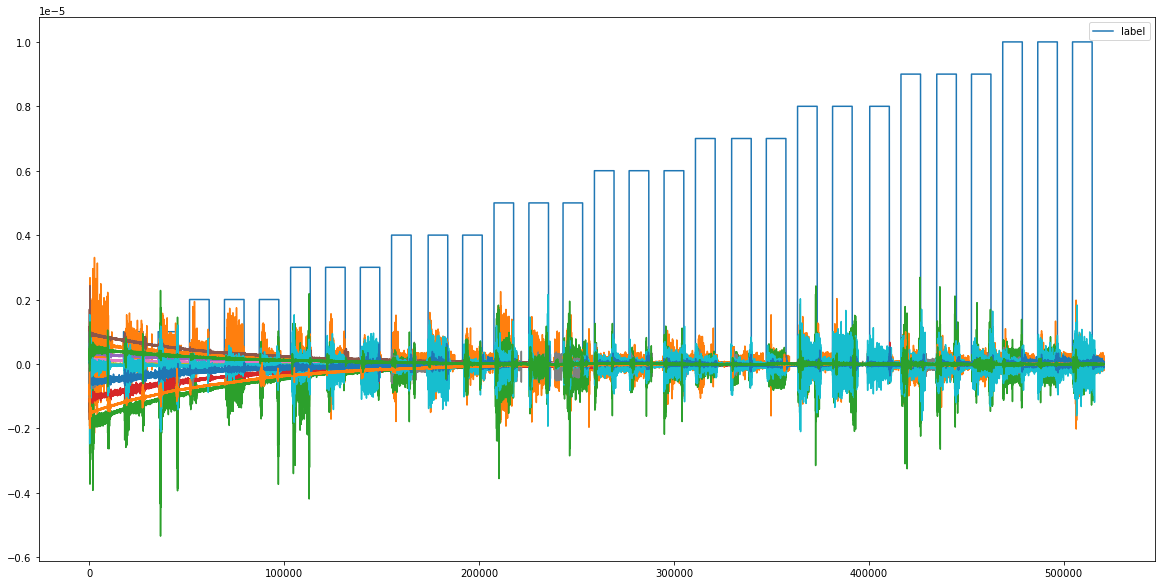

In [87]:
testx1_aft_window = testx1_aft_window.reset_index(drop = True)
testy1_aft_window = testy1_aft_window.reset_index(drop= True)

index = np.array(testx1_aft_window.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(testy1_aft_window*0.000001)
for i in tqdm(range(0,12)):
    ax.plot(index, testx1_aft_window[i])
    
line1.set_label('label')
ax.legend()
plt.show()

### find the testing set #2

In [75]:
# find the fisrt 200ms which is 385 data point

# find the ten start point
# ten_start_point is for the testing data set #2
counter = 0
label_number = [1,2,3,4,5,6,7,8,9,10]
checked_label = []
ten_start_point = []
for i in label_number:
    for j in tqdm(range(0, len(testy1_aft_window))):
        if testy1_aft_window.iloc[j,0] == i:
            if i not in checked_label:
                counter += 1
                checked_label.append(i)
                ten_start_point.append(j)
        if counter == 10:
            break
            
# find the ten new end point
# ten_end_point is for the testing data set #2
last = 1
ten_end_point = []
label_number = [1,2,3,4,5,6,7,8,9,10]
for j in label_number:
    last = j
    counter = 0
    for i in tqdm(range(ten_start_point[j-1], len(testy1_aft_window))):
        if i == len(testy1_aft_window)-1:
            ten_end_point.append(i)
        current = testy1_aft_window.iloc[i,0]
        if last == current:
            last = current
        else:
            last = current
            counter += 1
        if counter == 1:
            ten_end_point.append(i)
            break
            
testx2_aft_window = testx1_aft_window.iloc[ten_start_point[0]:ten_start_point[0]+385, :]
testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_end_point[0]:ten_end_point[0]+385, :])

for i in range(1,10):
#     if i == 9:
#         testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
#         testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_end_point[i]:220557, :])
#         break
    testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
    testx2_aft_window = testx2_aft_window.append(testx1_aft_window.iloc[ten_end_point[i]:ten_end_point[i]+385, :])

testy2_aft_window = testy1_aft_window.iloc[ten_start_point[0]:ten_start_point[0]+385, :]
testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_end_point[0]:ten_end_point[0]+385, :])

for i in range(1,10):
#     if i == 9:
#         testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
#         testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_end_point[i]:220557, :])
#         break
    testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_start_point[i]:ten_start_point[i]+385, :])
    testy2_aft_window = testy2_aft_window.append(testy1_aft_window.iloc[ten_end_point[i]:ten_end_point[i]+385, :])

### plot testing set #2

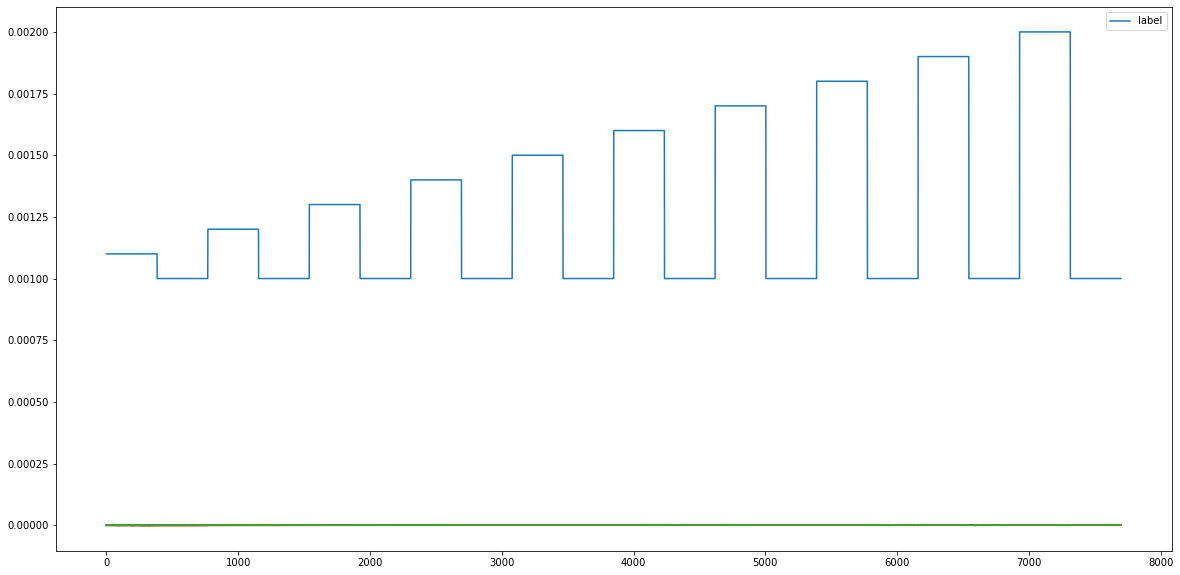

In [76]:
testx2_aft_window = testx2_aft_window.reset_index(drop = True)
testy2_aft_window = testy2_aft_window.reset_index(drop= True)

index = np.array(testx2_aft_window.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(testy2_aft_window*0.0001+0.001)
for i in tqdm(range(0,12)):
    ax.plot(index, testx2_aft_window[i])
    
line1.set_label('label')
ax.legend()
plt.show()

## SVM model

In [22]:
# svm_model = SVC()
# svm_model.fit(trainx,trainy)

# expected1 = testy1.values.flatten()
# predicted1 = svm_model.predict(testx1)
# expected2 = testy2.values.flatten()
# predicted2 = svm_model.predict(testx2)

### calculate the accuracy

In [23]:
# counter = 0
# for i in range(0, len(expected1)):
#     if expected1[i] == predicted1[i]:
#         counter += 1

# accuracy1 = counter/len(expected1)

# counter = 0
# for i in range(0, len(expected2)):
#     if expected2[i] == predicted2[i]:
#         counter += 1

# accuracy2 = counter/len(expected2)

### plot testing results

In [24]:
# index = np.array(testy1.index)
# fig, ax = plt.subplots(1, figsize = (20,10))
# line1, = ax.plot(predicted1*0.0001+0.001)
# line2, = ax.plot(expected1*0.0001+0.001)
    
# line1.set_label('predicted')
# line2.set_label('expected')
# ax.legend()
# plt.show()

# index = np.array(testy2.index)
# fig, ax = plt.subplots(1, figsize = (20,10))
# line1, = ax.plot(predicted2*0.0001+0.001)
# line2, = ax.plot(expected22*0.0001+0.001)
    
# line1.set_label('predicted')
# line2.set_label('expected')
# ax.legend()
# plt.show()

## KNN model

In [25]:
knn_model = KNeighborsClassifier(n_neighbors = 5)

In [26]:
knn_model.fit(trainx,trainy)

<ipython-input-26-afb52ebdfb61>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_model.fit(trainx,trainy)


KNeighborsClassifier()

In [27]:
expected1 = testy1.values.flatten()
predicted1 = knn_model.predict(testx1)

### calculate the accuracy

In [28]:
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy1 = counter/len(expected1)

In [29]:
accuracy1

0.4258211015073602

### plot testing results

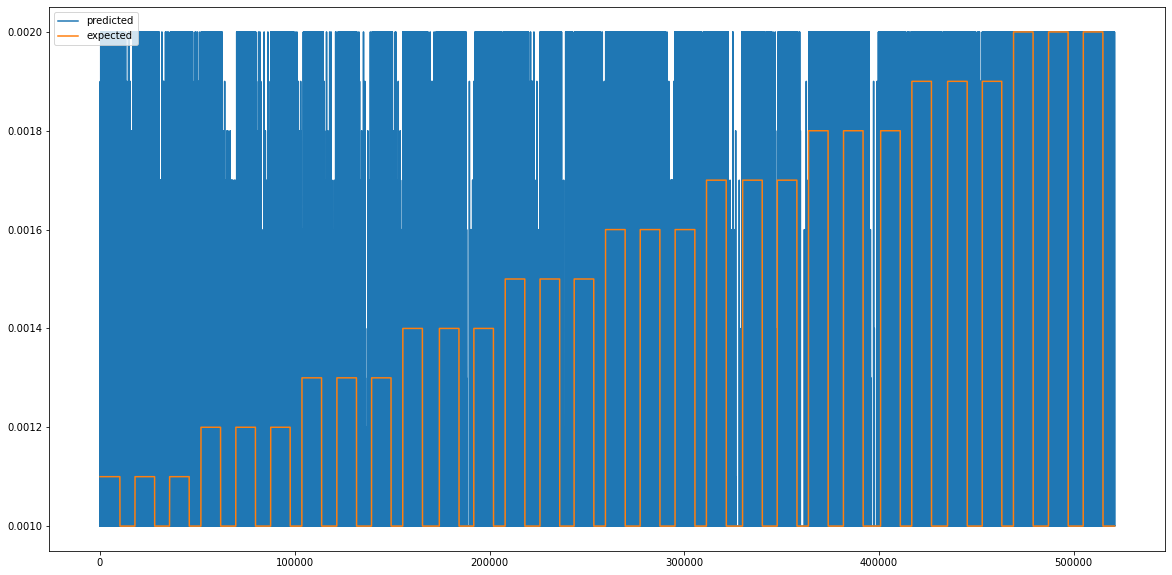

In [30]:
index = np.array(testy1.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted1*0.0001+0.001)
line2, = ax.plot(expected1*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

## lightGBM model

In [113]:
lightGBM_model = ltb.LGBMClassifier()

In [114]:
lightGBM_model.fit(trainx_aft_window,trainy_aft_window)

/Users/shuowang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier()

In [115]:
expected1 = testy1_aft_window.values.flatten()
predicted1 = lightGBM_model.predict(testx1_aft_window)

In [116]:
expected1
predicted1

array([1, 1, 1, ..., 0, 0, 0])

array([3, 3, 3, ..., 0, 0, 0])

### calculate the accuracy

In [117]:
counter = 0
for i in range(0, len(expected1)):
    if expected1[i] == predicted1[i]:
        counter += 1

accuracy1 = counter/len(expected1)

In [118]:
accuracy1

0.3187603486759457

### plot testing results

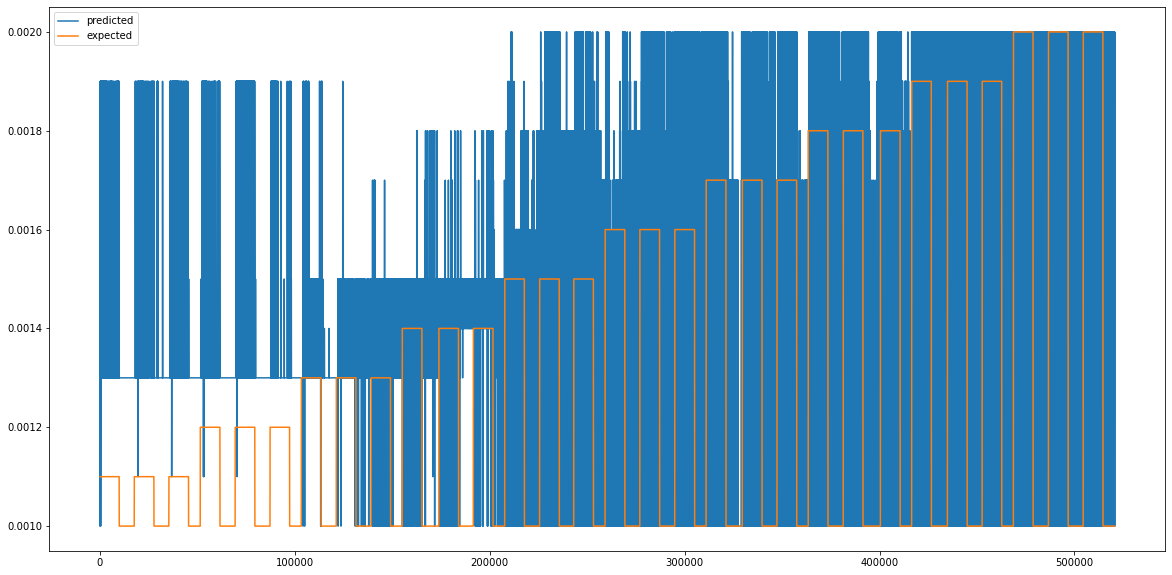

In [119]:
index = np.array(testy1.index)
fig, ax = plt.subplots(1, figsize = (20,10))
line1, = ax.plot(predicted1*0.0001+0.001)
line2, = ax.plot(expected1*0.0001+0.001)
    
line1.set_label('predicted')
line2.set_label('expected')
ax.legend()
plt.show()

## MLP model

In [71]:
# MLP_model = MLPClassifier(random_state=1, max_iter=300).fit(trainx,trainy)

/Users/shuowang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [72]:
# expected1 = testy1.values.flatten()
# predicted1 = MLP_model.predict(testx1)

### calculate the accuracy

In [75]:
# counter = 0
# for i in range(0, len(expected1)):
#     if expected1[i] == predicted1[i]:
#         counter += 1

# accuracy1 = counter/len(expected1)

In [77]:
# accuracy1

0.3725006051803437

0.49985574148874784

### plot testing results

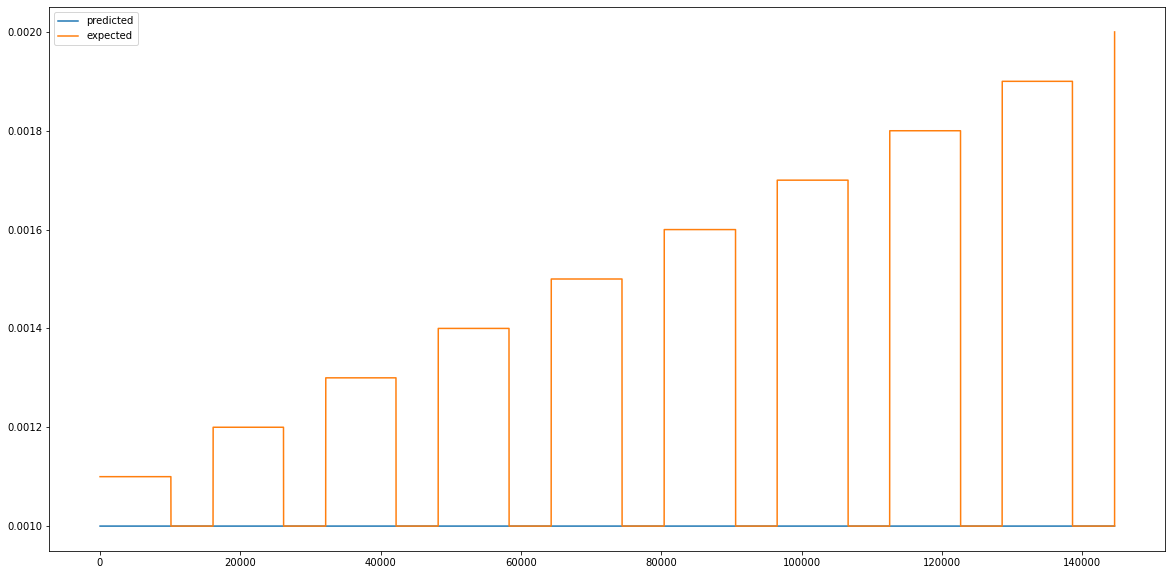

In [78]:
# index = np.array(testy1.index)
# fig, ax = plt.subplots(1, figsize = (20,10))
# line1, = ax.plot(predicted1*0.0001+0.001)
# line2, = ax.plot(expected1*0.0001+0.001)
    
# line1.set_label('predicted')
# line2.set_label('expected')
# ax.legend()
# plt.show()

In [109]:
trainx.to_csv('traintestdata/trainx.csv', header=False, index=False)
trainy.to_csv('traintestdata/trainy.csv', header=False, index=False)
testx1.to_csv('traintestdata/testx1.csv', header=False, index=False)
testy1.to_csv('traintestdata/testy1.csv', header=False, index=False)

In [110]:
trainx_aft_window.to_csv('traintestdata/trainx_aft_window.csv', header=False, index=False)
trainy_aft_window.to_csv('traintestdata/trainy_aft_window.csv', header=False, index=False)
testx1_aft_window.to_csv('traintestdata/testx1_aft_window.csv', header=False, index=False)
testy1_aft_window.to_csv('traintestdata/testy1_aft_window.csv', header=False, index=False)
testx2_aft_window.to_csv('traintestdata/testx2_aft_window.csv', header=False, index=False)
testy2_aft_window.to_csv('traintestdata/testy2_aft_window.csv', header=False, index=False)